In [1]:
from IPython.display import clear_output
import re
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stops = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from keras import initializers, regularizers, constraints
from keras.preprocessing import sequence
from keras.preprocessing import text as kptext
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, GRU, Dropout, GlobalMaxPooling1D, Input,Flatten,concatenate,SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


C:\Users\Joshua\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading datasets

In [2]:
train = pd.read_csv('data/train.csv')
train_app = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')
train_app = pd.read_csv('data/train.csv')

#train, valid = train_test_split(train, test_size=0.2)


## Data Exploration and Visualization
* According to the plot below, we can found that datasets is imbalance dataset. I am gonna resampe dataset to have uniform distribution.

In [3]:
'''tr_v = train.iloc[:,2:].sum()
plt.figure(figsize=(10,5))
ax= sns.barplot(tr_v.index, tr_v.values)

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = tr_v.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(rect.get_x())
    #print('get_width',rect.get_width())
    ax.text(rect.get_x() + rect.get_width()/2, 1.005*height, label, ha='center', va='bottom')
plt.show()'''


"tr_v = train.iloc[:,2:].sum()\nplt.figure(figsize=(10,5))\nax= sns.barplot(tr_v.index, tr_v.values)\n\nplt.ylabel('Number of Occurrences', fontsize=12)\nplt.xlabel('Type ', fontsize=12)\n\nrects = ax.patches\nlabels = tr_v.values\nfor rect, label in zip(rects, labels):\n    height = rect.get_height()\n    #print(rect.get_x())\n    #print('get_width',rect.get_width())\n    ax.text(rect.get_x() + rect.get_width()/2, 1.005*height, label, ha='center', va='bottom')\nplt.show()"

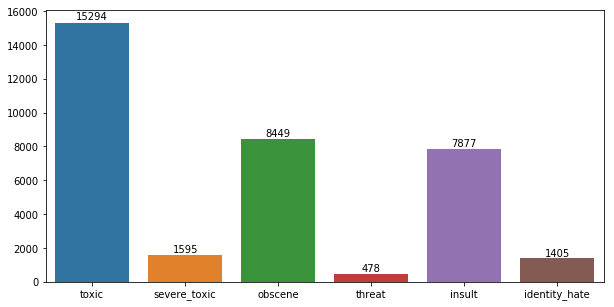

In [4]:
labels = list(train)[2:8]

label_sum = train[labels].sum()
plt.figure(figsize=(10,5))
ax= sns.barplot(label_sum.index, label_sum.values)
rects = ax.patches
labels =label_sum.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(rect.get_x())
    #print('get_width',rect.get_width())
    ax.text(rect.get_x() + rect.get_width()/2, 1.005*height, label, ha='center', va='bottom')
plt.show()

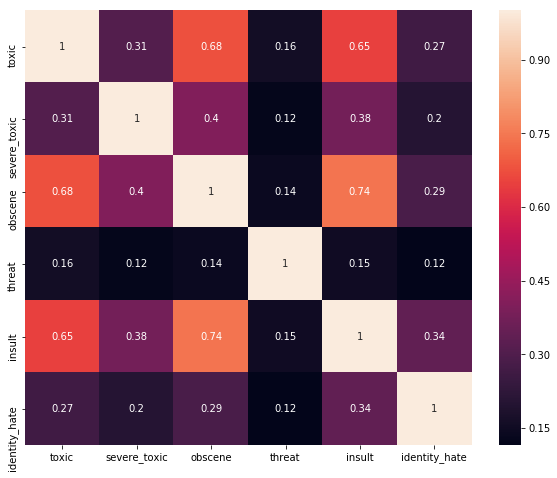

In [5]:
%matplotlib inline
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(train.corr(), annot=True)


In [6]:
pd.set_option('display.max_colwidth', -1)
train.loc[[1,2,5],['comment_text']]

,comment_text
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
5,"""\n\nCongratulations from me as well, use the tools well. · talk """


## Resampling data
* I add copies of instances from the under-represented to even-up the classes

In [7]:
train1=train_app[(train_app.identity_hate==1) &  (train_app.toxic==0)].sample(n=11000,replace=True)

train_app=train_app.append(train1, ignore_index=True)
train1=train_app[(train_app.threat==1) &  (train_app.toxic==0)].sample(n=14000,replace=True)

train_app=train_app.append(train1, ignore_index=True)
train1=train_app[(train_app.obscene==1) &  (train_app.identity_hate==1)& (train_app.toxic==0)& (train_app.insult==0)].sample(n=2000,replace=True)

train_app=train_app.append(train1, ignore_index=True)

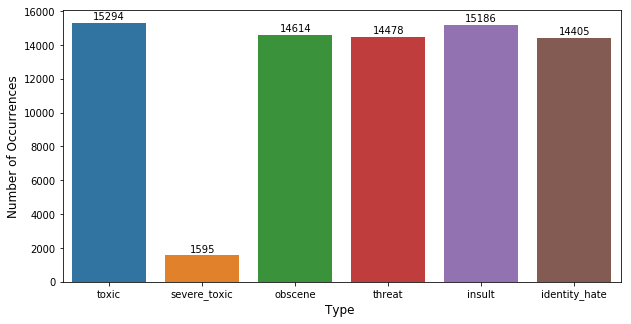

In [8]:
tr_av = train_app.iloc[:,2:].sum()
plt.figure(figsize=(10,5))
ax= sns.barplot(tr_av.index, tr_av.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = tr_av.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(rect.get_x())
    #print('get_width',rect.get_width())
    ax.text(rect.get_x() + rect.get_width()/2, 1.005*height, label, ha='center', va='bottom')
plt.show()

In [9]:
print("The number of toxic get 1:",train[(train.toxic==1)].shape[0])
print("The number of severe_toxic get 1:",train[(train.severe_toxic==1)].shape[0])
print("The number of toxic and severe_toxic both get 1: ",
      train[(train.severe_toxic==1)&(train.toxic==1)].shape[0])

The number of toxic get 1: 15294
The number of severe_toxic get 1: 1595
The number of toxic and severe_toxic both get 1:  1595


* We can found that sever_toxic comments are always toxic, so that  We increase the number of toxic and also increase the number of severe_toxic.

# Preprocessing

In [10]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'[?|$|.|!]',r'',text)
    
    
    text = re.sub(r"\n", " ",text)
    text = re.sub("'", " ",text)
    text = re.sub(",", " ",text)
    text = re.sub(r"\"", " ",text)
    #text = re.sub(r"\'", " ",text)
    text = re.sub(r"\.", " ",text)
    tokens = nltk.word_tokenize(text)
    tokens =[ token for token in tokens if token.isalpha()]
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens if t not in stops]
    #tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens ]
    return " ".join(tokens)
    #return tokens

# Transforming Text to Sequences

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features = 2000
maxlen = 100


In [12]:
train_=train_app["comment_text"].fillna("no comment").values
#valid_=valid["comment_text"].fillna("no comment").values
test_=test["comment_text"].fillna("no comment").values

In [13]:
train_comments = [preprocess(text) for text in train_]
#valid_comments = [preprocess(text) for text in valid_]
#test_comments = [preprocess(text) for text in test_]

tokenizer = Tokenizer(num_words=max_features)  
tokenizer.fit_on_texts(train_comments)


tr_sequ = tokenizer.texts_to_sequences(train_comments)
#va_sequ = tokenizer.texts_to_sequences(valid_comments)
#te_sequ = tokenizer.texts_to_sequences(test_comments)


tr_data = sequence.pad_sequences(tr_sequ, maxlen=maxlen)
#va_data = sequence.pad_sequences(va_sequ, maxlen=maxlen)
#te_data = sequence.pad_sequences(te_sequ, maxlen=maxlen)

print(' %s unique words'%len(tokenizer.word_index))
print('Shape of train_data:', tr_data.shape)
labels_types = list(train)[2:8]
train_labels = train_app[labels_types].values
print('Shape of train_label:', train_labels.shape)

#print('Shape of valid_data:', va_data.shape)
#labels_types = list(valid)[2:8]
#valid_labels = train[labels_types].values
#print('Shape of valid_label:', train_labels.shape)

#print('Shape of test_data:', te_data.shape)

#print('Shape of label :', train_labels.shape)



 159644 unique words
Shape of train_data: (186571, 100)
Shape of train_label: (186571, 6)


In [14]:
train_comments[:1]


['explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired']

In [15]:
tr_data[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  493,   56,   67,
         596,  825,  217,  133,   51, 1143,    8,  169,  206,    5,    2,
          88]])

## TextCNN Model
<img src="texcnn.png" ; width="700">
ref:http://www.aclweb.org/anthology/D14-1181

In [16]:
def text_cnn():
    filter_nums = 256
    output_units = 6
    embed_size = 256
    dropout = 0.1
    input_layer = Input(shape=(maxlen,), dtype='int32')
    embedding_layer = Embedding(max_features,  embed_size, input_length=maxlen,)(input_layer)
   
    
    conv_0 = Conv1D(filter_nums, 2, kernel_initializer="normal", padding="same", activation="tanh")(embedding_layer)
    #conv_0 = BatchNormalization()(conv_0)
    conv_1 = Conv1D(filter_nums, 3, kernel_initializer="normal", padding="same", activation="tanh")(embedding_layer)
    #conv_1 = BatchNormalization()(conv_1)
    conv_2 = Conv1D(filter_nums, 4, kernel_initializer="normal", padding="same", activation="tanh")(embedding_layer)
    #conv_2 = BatchNormalization()(conv_2)
    #conv_3 = Conv1D(filter_nums, 5, kernel_initializer="normal", padding="valid", activation="tanh")(embedding_layer)

    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    #maxpool_3 = GlobalMaxPooling1D()(conv_3)
    
    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2])
    #out = Dropout(0.5)(merged_tensor)
    #h1 = Dense(units=128, activation="relu")(out)
    #h2 = Dense(units=32, activation="relu")(merged_tensor)
    output = Dense(units=output_units, activation='sigmoid')(merged_tensor)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auc_roc])
    return model

In [17]:
import tensorflow as tf
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [18]:
#test_labels.drop('id',axis=1, inplace=True)
tr_labels = np.array(train_labels)
#te_labels = np.array(test_labels)
print('train_labels',tr_labels.shape)

#print('test_labels',te_labels.shape)
print('tr_labels',tr_labels.shape)

train_labels (186571, 6)
tr_labels (186571, 6)


In [19]:
model = text_cnn()
batch_size = 256
epochs = 20
model.fit(tr_data, tr_labels,
              validation_split=0.2,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True)
#scores = model.evaluate(te_data, te_labels)




Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Train on 149256 samples, validate on 37315 samples
Epoch 1/20
149256/149256 [==============================] - 26s 171us/step - loss: 0.0742 - acc: 0.9778 - auc_roc: 0.8756 - val_loss: 0.6713 - val_acc: 0.7946 - val_auc_roc: 0.9190
Epoch 2/20
149256/149256 [==============================] - 23s 155us/step - loss: 0.0524 - acc: 0.9816 - auc_roc: 0.8870 - val_loss: 0.6500 - val_acc: 0.7858 - val_auc_roc: 0.8984
Epoch 3/20
149256/149256 [==============================] - 23s 156us/step - loss: 0.0482 - acc: 0.9828 - auc_roc: 0.8955 - val_loss: 0.4573 - val_acc: 0.8238 - val_auc_roc: 0.9054
Epoch 4/20
149256/149256 [==============================] - 23s 156us/step - loss: 0.0437 - acc: 0.9842 - auc_roc: 0.9131 - val_loss: 0.3687 - val_acc: 0.8349 - val_auc_roc: 0.9201
Epoch 5/20
149256/149256 [==============================] - 23s 157us/step - loss: 0.0

In [20]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 256)     512000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     131328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 256)     196864      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [21]:
X_train, X_valid, y_train, y_valid, = train_test_split(tr_data, tr_labels, test_size=0.2, random_state=0)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)


In [22]:
print('The training accuracy is', train_accuracy)
print('The training roc_auc_score is', roc_auc_score(y_train, y_train_pred))
print('-----------------------------------------------------')
print('The testing accuracy is', valid_accuracy)
print('The testing roc_auc_score is', valid_accuracy)

The training accuracy is 0.9943586857479766
The training roc_auc_score is 0.985464527032784
-----------------------------------------------------
The testing accuracy is 0.8475948010183573
The testing roc_auc_score is 0.8475948010183573


## Top 10 Words per class

In [23]:
from collections import Counter
toxic_counts= Counter()
severe_toxic_counts= Counter()
obscene_counts= Counter()
threat_counts= Counter()
insult_counts= Counter()
identity_hate_counts= Counter()


In [24]:
for i in range(len(train_comments)):
    if train_app['toxic'][i]==1:
        toxic_words = train_comments[i].split(' ')
        for word in toxic_words:
            toxic_counts[word] += 1

for i in range(len(train_comments)):
    if train_app['severe_toxic'][i]==1:
        severe_toxic_words = train_comments[i].split(' ')
        for word in severe_toxic_words:
            severe_toxic_counts[word] += 1

for i in range(len(train_comments)):            
    if train_app['obscene'][i]==1:
        obscene_words = train_comments[i].split(' ')
        for word in obscene_words:
            obscene_counts[word] += 1
    
    
for i in range(len(train_comments)):    
    if train_app['threat'][i]==1:
        threat_words = train_comments[i].split(' ')
        for word in threat_words:
            threat_counts[word] += 1
    
for i in range(len(train_comments)):    
    if train_app['insult'][i]==1:
        insult_words = train_comments[i].split(' ')
        for word in insult_words:
            insult_counts[word] += 1
for i in range(len(train_comments)):    
    if train_app['identity_hate'][i]==1:
        identity_hate_words = train_comments[i].split(' ')
        for word in identity_hate_words:
            identity_hate_counts[word] += 1

toxic = pd.DataFrame(toxic_counts.most_common(10))
severe_toxic = pd.DataFrame(severe_toxic_counts.most_common(10))
threat = pd.DataFrame(threat_counts.most_common(10))
insult = pd.DataFrame(insult_counts.most_common(10))
identity_hate = pd.DataFrame(identity_hate_counts.most_common(10))
obscene = pd.DataFrame(obscene_counts.most_common(10))

print('fininsh')

fininsh


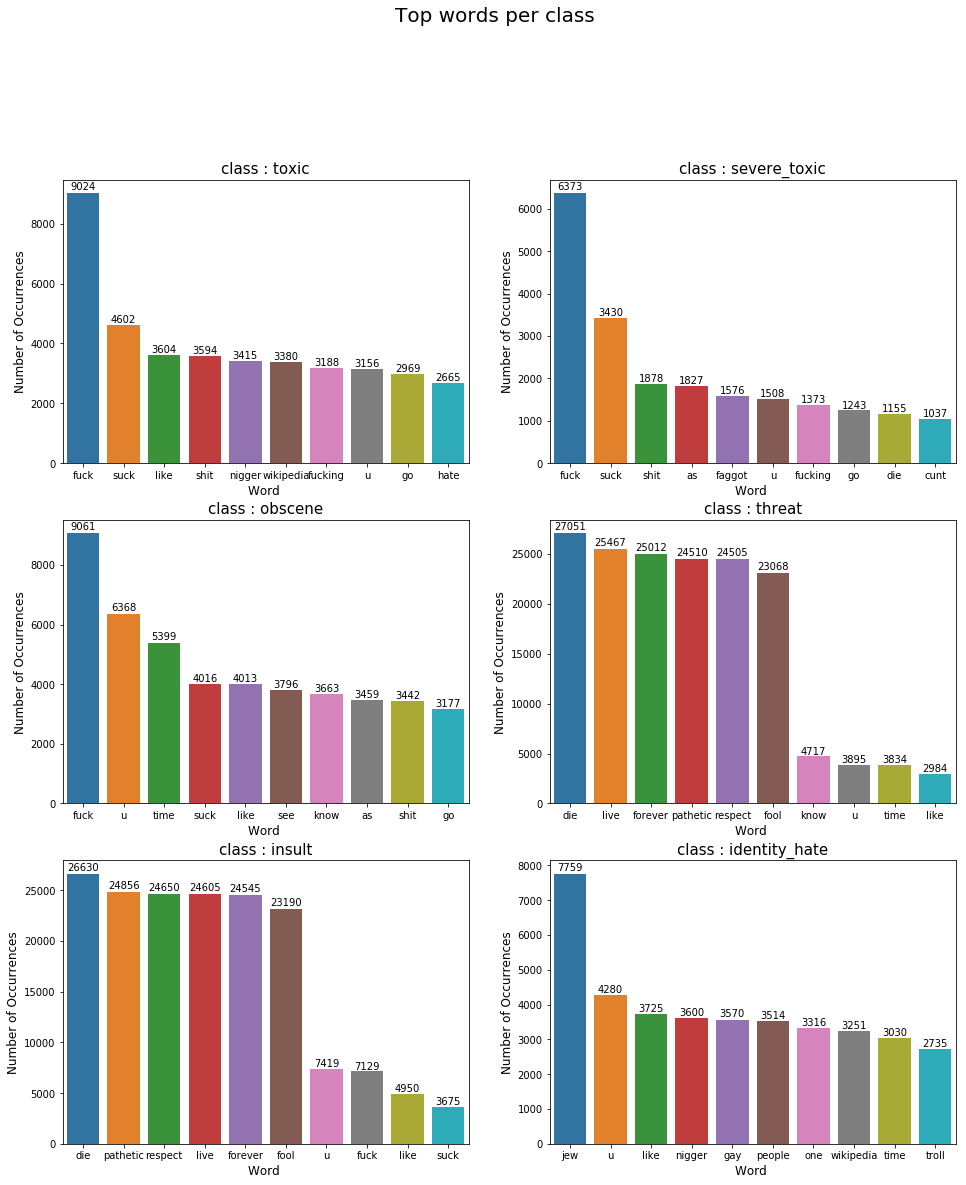

In [25]:
plt.figure(figsize=(16,24))
plt.suptitle("Top words per class",fontsize=20)
gridspec.GridSpec(4,2)

#toxic
plt.subplot2grid((4,2),(0,0))
ax= sns.barplot(toxic[0], toxic[1])
plt.title("class : toxic",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects = ax.patches
labels = toxic[1].values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')

#severe_toxic
plt.subplot2grid((4,2),(0,1))
bx= sns.barplot(severe_toxic[0], severe_toxic[1])
plt.title("class : severe_toxic",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects_b = bx.patches
labels_b = severe_toxic[1].values
for rect, label in zip(rects_b, labels_b):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')

#obscene
plt.subplot2grid((4,2),(1,0))
bx= sns.barplot(obscene[0], obscene[1])
plt.title("class : obscene",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects_b = bx.patches
labels_b = obscene[1].values
for rect, label in zip(rects_b, labels_b):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')    

    
    
#threat
plt.subplot2grid((4,2),(1,1))
bx= sns.barplot(threat[0], threat[1])
plt.title("class : threat",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects_b = bx.patches
labels_b = threat[1].values
for rect, label in zip(rects_b, labels_b):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')    

#insult
plt.subplot2grid((4,2),(2,0))
bx= sns.barplot(insult[0], insult[1])
plt.title("class : insult",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects_b = bx.patches
labels_b = insult[1].values
for rect, label in zip(rects_b, labels_b):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')        
    
#identity_hate
plt.subplot2grid((4,2),(2,1))
bx= sns.barplot(identity_hate[0], identity_hate[1])
plt.title("class : identity_hate",fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word ', fontsize=12)
rects_b = bx.patches
labels_b = identity_hate[1].values
for rect, label in zip(rects_b, labels_b):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, 1.005*height , label, ha='center', va='bottom')        
    
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
plt.show()